In [12]:
from pyspecter.SPECTER import SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import initialize, newplot
initialize()

# JAX imports
import jax
import jax.numpy as jnp


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

In [13]:
# CMS Open Sim Parameters
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 10 # Note that runtime is pad^2, memory is pad^4

n_samples = 100
batch_size = 250 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = n_samples, )
weights = sim_weights * k_factors

# dataset = load_triangles(num_angles=18, num_energies=18, R = 1)

compiled_compute_spectral_representation = jax.jit(jax.vmap(compute_spectral_representation,))
spectral_events = compiled_compute_spectral_representation(dataset)

print(type(spectral_events))

print(dataset.shape)
print(np.sum(dataset[0,:,0]))

Max # of particles: 113
<class 'jaxlib.xla_extension.ArrayImpl'>
(100, 10, 3)
1.0


In [23]:
# #############################################
# ########## Spectral EMD Calculator ##########
# #############################################

def weighted_sum(s, p = 2, max_index = None, inclusive = True):
    
    if max_index is None:
        return jnp.sum(s[:,1] * jnp.power(s[:,0], p), axis = -1)
    else:
        max_index = max_index + 1 if inclusive else max_index
        return jnp.sum(s[:max_index,1] * jnp.power(s[:max_index,0], p),axis = -1)



def cross_term(s1, s2):

    # Cross term
    omega1s = s1[:,0]
    omega2s = s2[:,0]

    E1s = s1[:,1]
    E2s = s2[:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((jnp.array((E1_cumsums[0],)), E1_cumsums[:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((jnp.array((E2_cumsums[0],)), E2_cumsums[:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,None] * omega2s[None,:]
    minE = jnp.minimum(E1_cumsums[:,None], E2_cumsums[None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,None], shifted_E2_cumsums[None,:])
    x = minE - maxE

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))


    return cross_term



def find_indices_jax(X, Y):


    def condition(state):
        step, i, j, j_prev, _ = state
        return (jax.lax.lt(i, X_length) & jax.lax.lt(j, Y_length))

    def body(state):
        step, i, j, j_prev, result = state
        x_gt_y = jnp.take(X, i) > jnp.take(Y, j - 1)
        y_gt_x = jnp.take(Y, j) > jnp.take(X, i - 1)

        # jax.debug.print("{x}, {y}, {x2}, {y2}", x = jnp.take(X, i), y = jnp.take(Y, j-1), x2 = jnp.take(X, i-1), y2 = jnp.take(Y, j))
        # jax.debug.print("{x}, {y}", x = x_gt_y, y = y_gt_x)

        # Conditionals to update i and j
        advance_i = (x_gt_y & y_gt_x)
        advance_i_2 = ((jnp.take(X, i) < jnp.take(Y, j-1))) & ~advance_i
        advance_j = ~advance_i & ~advance_i_2

        next_i = i + jax.lax.select(advance_i | advance_i_2, 1, 0)
        next_j = j + jax.lax.select(advance_j, 1, 0)
        next_j_prev = j_prev + jax.lax.select(advance_j, 1, 0)

        next_result = jax.lax.cond(
            x_gt_y & y_gt_x,
            lambda _: jnp.array([i, j], dtype=jnp.int32),
            lambda _: jnp.array([-1, -1], dtype=jnp.int32),
            None
        )

        # if advance_i_2, reset both j and j_prev to j_prev
        # next_j = jax.lax.select(advance_i_2, j_prev, next_j)
        # next_j_prev = jax.lax.select(advance_i_2, j_prev, next_j_prev) 

        next_result = result.at[step].set(next_result)
        return (step + 1, next_i, next_j, next_j_prev, next_result)
    


    step = 0
    i_init = 1
    j_init = 1
    j_prev_init = 1
    X_length, Y_length = X.shape[-1], Y.shape[-1]
    max_length = X_length + Y_length
    initial_state = (step, i_init, j_init, j_prev_init, jnp.full((max_length, 2), -1, dtype=jnp.int32), )

    _, _, _, _, final_result = jax.lax.while_loop(condition, body, initial_state)

    return final_result


# Function to find indices on X and Y, then Y and X, and combine:
def find_indices(X, Y):
        
        x_size = X.shape[0]
        y_size = Y.shape[0]
    
        # Find indices on X and Y
        indices = find_indices_jax(X, Y)
        i_indices, j_indices = indices[:,0], indices[:,1]
        # i_indices = i_indices[jnp.where(i_indices > -1, size = x_size + y_size, fill_value=-1)]
        # j_indices = j_indices[jnp.where(j_indices > -1, size = x_size + y_size, fill_value=-1)]
    
        # Find indices on Y and X
        indices = find_indices_jax(Y, X)
        j_indices_2, i_indices_2 = indices[:,0], indices[:,1]
        # i_indices_2 = i_indices_2[jnp.where(i_indices_2 > -1, size = x_size + y_size, fill_value=-1)]
        # j_indices_2 = j_indices_2[jnp.where(j_indices_2 > -1, size = x_size + y_size, fill_value=-1)]
    
        # Combine
        i_indices = jnp.concatenate((i_indices, i_indices_2))
        j_indices = jnp.concatenate((j_indices, j_indices_2))

        # Remove duplicates
        indices = jnp.unique(jnp.stack((i_indices, j_indices), axis = -1), size = 2 * (x_size + y_size), fill_value = -1, axis = 0)
        mask = (indices[:,0] > -1) * (indices[:,1] > -1)

        return indices, mask



import jax.numpy as jnp
from jax import vmap, jit

def find_insertion_index(x, Y):
    """Find the index in Y where x should be inserted."""
    return jnp.searchsorted(Y, x, side='right')

@jit
def find_indices_2(X, Y):
    # Find the indices where elements of X should be inserted in Y
    positions_in_Y = vmap(find_insertion_index, in_axes=(0, None))(X, Y)

    # Compute the i, j indices based on the given conditions
    condition1 = (jnp.roll(X, -1, axis=0)[:-1] < Y[positions_in_Y[:-1]])
    condition2 = (X[:-1] > jnp.roll(Y, 1, axis=0)[positions_in_Y[:-1]])
    valid_mask = condition1 & condition2

    # Prepare a fixed-size output with a mask to indicate valid pairs
    i_indices = jnp.arange(X.shape[0] - 1)
    j_indices = positions_in_Y[:-1]

    return i_indices, j_indices, valid_mask




def cross_term_improved(s1, s2):

    # Cross term
    omega1s = s1[:,0]
    omega2s = s2[:,0]

    E1s = s1[:,1]
    E2s = s2[:,1]

    # Calculate cumulative spectral functions
    cumulative_inclusive_1 = jnp.cumsum(E1s, axis = -1)
    cumulative_inclusive_2 = jnp.cumsum(E2s, axis = -1)

    Etot1 = jnp.sum(E1s)
    Etot2 = jnp.sum(E2s)

    # Exclusive = inclusive - 2EE
    cumulative_exclusive_1 = cumulative_inclusive_1 - E1s
    cumulative_exclusive_2 = cumulative_inclusive_2 - E2s

    # O(n4) parts -- determine which indices survive the theta function
    i_indices, j_indices, mask = find_indices_2(cumulative_inclusive_1, cumulative_inclusive_2)
    # i_indices, j_indices = indices[:,0], indices[:,1]

    
    # O(n2) parts -- calculate the cross term using the nonzero indices
    omega_n_omega_l = omega1s[i_indices] * omega2s[j_indices]
    minE = -jnp.maximum(Etot1 - cumulative_inclusive_1[i_indices], Etot2 - cumulative_inclusive_2[j_indices]) + jnp.minimum(Etot1 - cumulative_exclusive_1[i_indices], Etot2 -  cumulative_exclusive_2[j_indices])


    cross = omega_n_omega_l * minE
    cross_term = jnp.sum(cross * mask, axis = (-1))


    return cross_term


def theta(x):

    return x > 0 


def ds2(s1, s2):

    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term(s1, s2)

def ds2_improved(s1, s2):

    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term_improved(s1, s2)



def loc(s1, s2):

    # Cross term
    omega1s = s1[:,0]
    omega2s = s2[:,0]

    E1s = s1[:,1]
    E2s = s2[:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((jnp.array((E1_cumsums[0],)), E1_cumsums[:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((jnp.array((E2_cumsums[0],)), E2_cumsums[:-1]), axis = -1) 

    
    omega_n_omega_l = omega1s[:,None] * omega2s[None,:]
    minE = jnp.minimum(E1_cumsums[:,None], E2_cumsums[None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,None], shifted_E2_cumsums[None,:])
    x = minE - maxE

    indices_original = jnp.where(x > 0)
    i_original, j_original = indices_original[0], indices_original[1]
    omega_n_omega_l_original = omega1s[i_original,None] * omega2s[None,j_original]



    omega_n_omega_l = omega1s[:,None] * omega2s[None,:]
    x_indices, y_indices, mask = find_indices_2(E1_cumsums, E2_cumsums)
    # x_indices, y_indices = indices[:,0], indices[:,1]
    # x_indices = x_indices[jnp.where(x_indices > -1)]
    # y_indices = y_indices[jnp.where(y_indices > -1)]
    y = jnp.zeros_like(E1_cumsums[:,None] * E2_cumsums[None,:])
    omega_n_omega_l = omega1s[x_indices,None] * omega2s[None,y_indices]


    for i, j, valid in zip(x_indices, y_indices, mask):
        y = y.at[i,j].set(y[i,j] + 1 * valid)

    data_size = (omega_n_omega_l.size * omega_n_omega_l.itemsize + x.size * x.itemsize + theta(x).size * theta(x).itemsize)
    # print individual array sizes and total size in GigaBytes
    # print("omega_n_omega_l size: ", omega_n_omega_l.size * omega_n_omega_l.itemsize / 1e9)
    # print("x size: ", x.size * x.itemsize / 1e9)
    # print("theta(x) size: ", theta(x).size * theta(x).itemsize / 1e9)
    # print("Total size: ", data_size     / 1e9)
    # print(theta(x).sum())
    


    # # Calculate cumulative spectral functions
    # cumulative_inclusive_1 = jnp.cumsum(E1s, axis = -1)
    # cumulative_inclusive_2 = jnp.cumsum(E2s, axis = -1)

    # # Exclusive = inclusive - 2EE
    # cumulative_exclusive_1 = cumulative_inclusive_1 - E1s
    # cumulative_exclusive_2 = cumulative_inclusive_2 - E2s

    # # O(n4) parts -- determine which indices survive the theta function
    # y = (cumulative_inclusive_1[:,None] - cumulative_exclusive_2[None,:] > 0) * ((cumulative_inclusive_2[None,:] - cumulative_exclusive_1[:,None] > 0))
    return theta(x), y
     

    



0.008497013
0.009941599


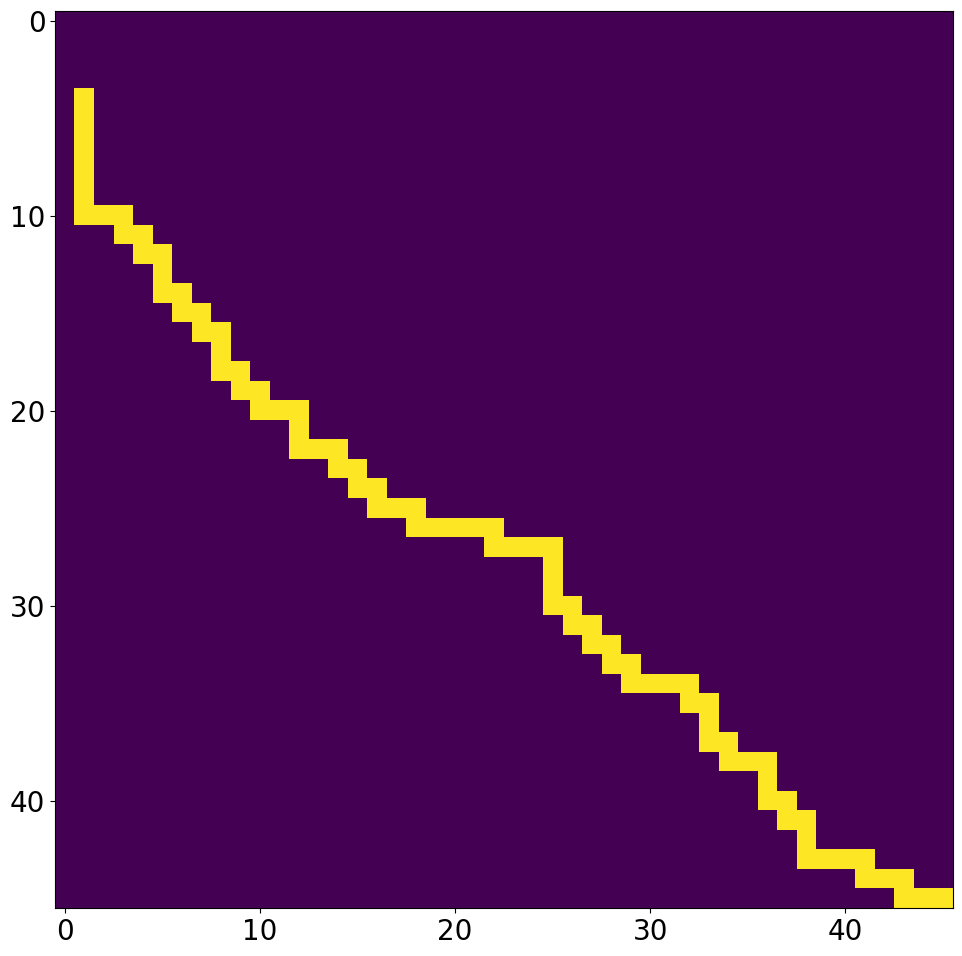

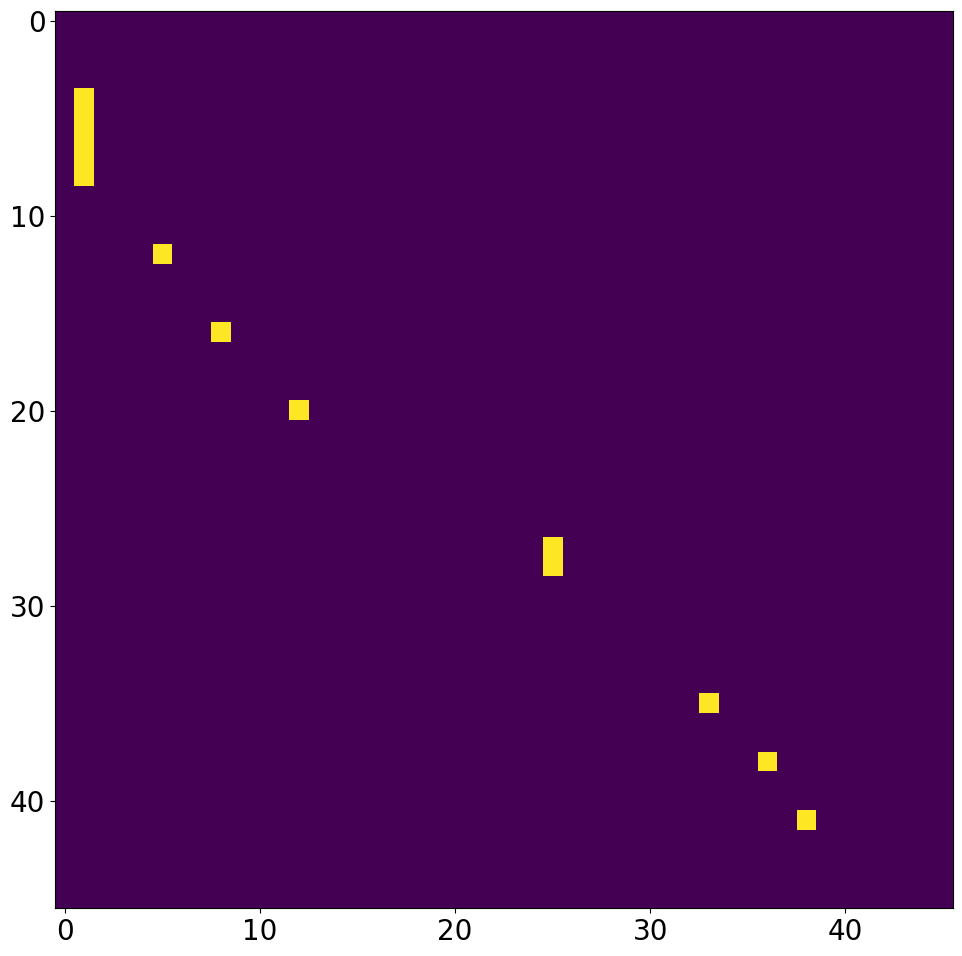

TypeError: sub does not accept dtype bool at position 0. Accepted dtypes at position 0 are subtypes of floating, integer, complexfloating.

<Figure size 1000x1000 with 0 Axes>

In [25]:
print(ds2(spectral_events[8], spectral_events[2]))
print(ds2_improved(spectral_events[8], spectral_events[2]))

loc1, loc2 = loc(spectral_events[8], spectral_events[2])

# Imshow the loc1 and loc2 matrices
plt.figure(figsize=(10,10))
plt.imshow(loc1)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(theta(loc2))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.abs(loc1 - theta(loc2)))
plt.show()

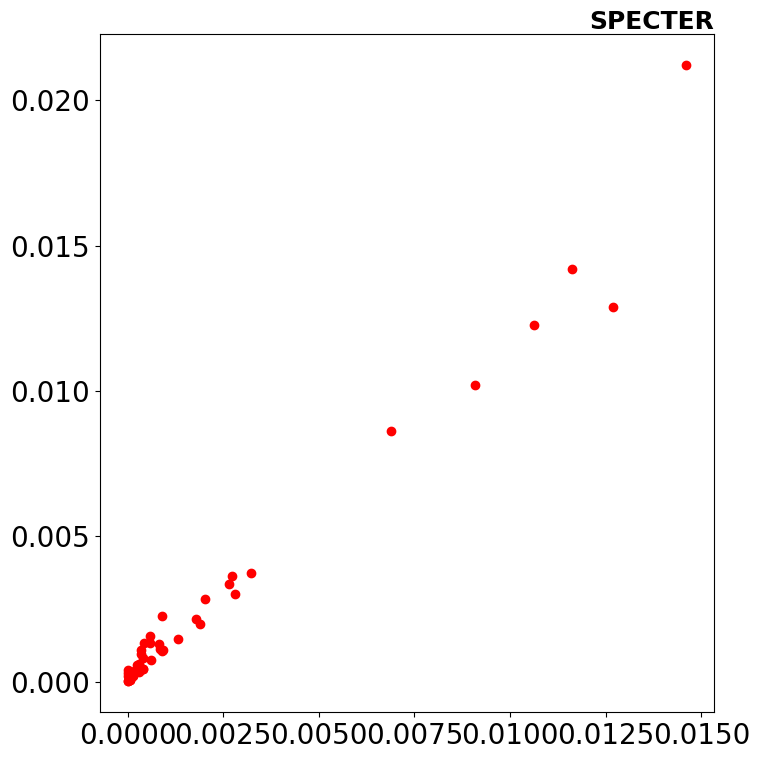

In [16]:
# Check ds2_improved vs ds2 for a bunch of events and plot

ds2s = []
ds2s_improved = []
for i in range(50):
    ds2s.append(ds2(spectral_events[i], spectral_events[-i-2]))
    ds2s_improved.append(ds2_improved(spectral_events[i], spectral_events[-i-2]))

newplot()
plt.scatter(ds2s, ds2s_improved)


In [17]:
# compile and vectorize ds2 and ds2_improved
compiled_ds2 = jax.vmap(jax.jit(ds2,))
compiled_ds2_improved = jax.vmap(jax.jit(ds2_improved,))

test1 = compiled_ds2(spectral_events[:5], spectral_events[:5][::-1])
test2 = compiled_ds2_improved(spectral_events[:5], spectral_events[:5][::-1])

print(ds2(spectral_events[0], spectral_events[1]), ds2_improved(spectral_events[0], spectral_events[1]))

0.009561313 0.01445888


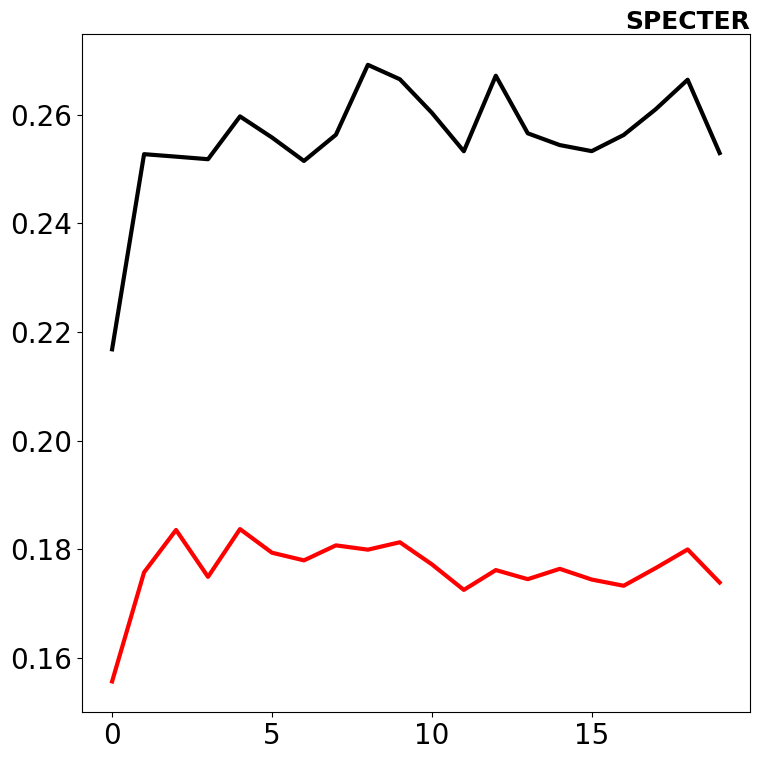

In [18]:
# time ds2 and ds2_improved on batches of n events as n increases and plot the time 
times = []
times_improved = []
for i in range(1, 100, 5):
    start = time.time()
    test1 = compiled_ds2(spectral_events[:i], spectral_events[:i][::-1])
    end = time.time()
    times.append(end - start)

    start = time.time()
    test2 = compiled_ds2_improved(spectral_events[:i], spectral_events[:i][::-1])
    end = time.time()
    times_improved.append(end - start)

newplot()
plt.plot(times)
plt.plot(times_improved)


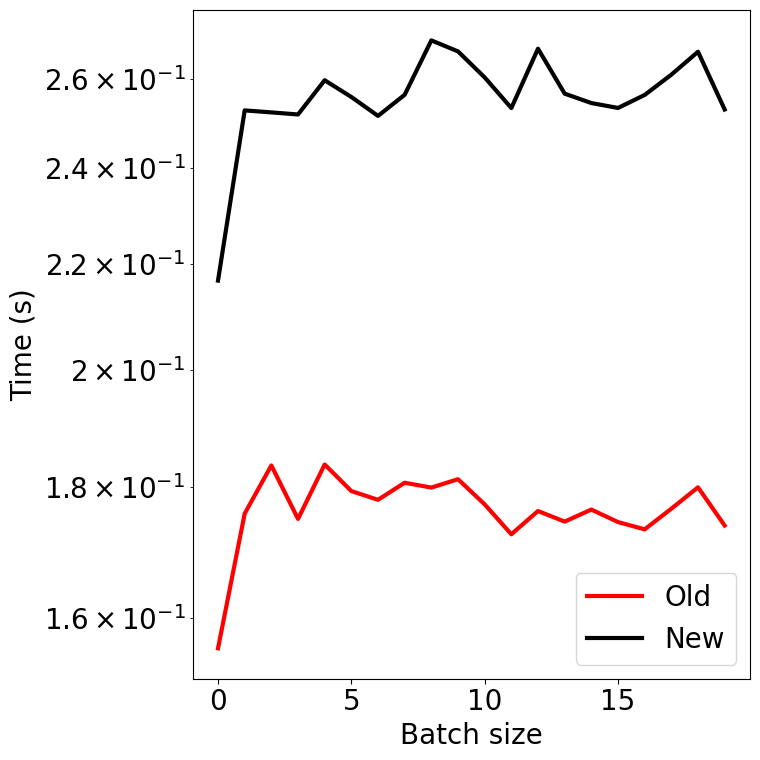

In [19]:
plt.plot(times, label = "Old")
plt.plot(times_improved, label = "New")
plt.yscale('log')

plt.xlabel("Batch size")
plt.ylabel("Time (s)")
plt.legend()

In [20]:

# Function to load in 1000 events with a pad size of n and time the computation of ds2 and ds2_improved
def time_ds2(pad, f):

    n_samples = 10000
    events_1 = np.random.rand(n_samples, pad, 3)
    events_2 = np.random.rand(n_samples, pad, 3)

    events_1[:,:,0] /= np.sum(events_1[:,:,0], axis = -1)[:,None]
    events_2[:,:,0] /= np.sum(events_2[:,:,0], axis = -1)[:,None]

    spectral_events_1 = compiled_compute_spectral_representation(events_1)
    spectral_events_2 = compiled_compute_spectral_representation(events_2)

    batch_size = 100
    indices = np.arange(n_samples)

    start = time.time()

    compiled_f = jax.jit(jax.vmap(f))

    for n in range(0, n_samples, batch_size):

        # print(f"Computing Batch {n}-{n+batch_size} of {len(n_samples)} pairs. Elapsed Time: {time.time() - n_samples :.3f} seconds")
        i_batch = indices[n : n + batch_size]
        j_batch = indices[n : n + batch_size]
        
        # Compute the pairwise EMDs
        emds = compiled_f(spectral_events_1[i_batch], spectral_events_2[j_batch])

        if n == 0:
            batch1_time = time.time() - start
            print(f"Batch 1 time: {batch1_time:.3f} seconds")
    
    return time.time() - start


    # print("Compiling ...")
    # compiled_ds2 = jax.jit(jax.vmap(ds2,))
    # compiled_ds2_improved = jax.jit(jax.vmap(ds2_improved,))

    # # run once to compile
    # try:
    #     test1 = compiled_ds2(spectral_events[:2], spectral_events[:2])
    # except:
    #     pass

    # try:
    #     test2 = compiled_ds2_improved(spectral_events[:2], spectral_events[:2])
    # except:
    #     pass

    # Start timing
    print("Timing ...")
    try:
        start = time.time()
        spectral_events_1 = compiled_compute_spectral_representation(events_1)
        spectral_events_2 = compiled_compute_spectral_representation(events_2)
        test1 = compiled_ds2(spectral_events_1, spectral_events_2)
        end = time.time()
        time_old = end - start
    except :
        print("XLA error")
        time_old = np.nan

    try:
        start = time.time()
        spectral_events_1 = compiled_compute_spectral_representation(events_1)
        spectral_events_2 = compiled_compute_spectral_representation(events_2)
        test2 = compiled_ds2_improved(spectral_events_1, spectral_events_2)
        end = time.time()
        times_improved = end - start
    except :
        print("XLA error")
        times_improved = np.nan

    return time_old, times_improved

In [21]:
n = np.logspace(0, 3, 15).astype(np.int32)
n_times = []

for i in n:
    print("Running with pad size: ", i)
    n_times.append([time_ds2(i, ds2), time_ds2(i, ds2_improved)])
    print("Finished with pad size: ", i)
    print("Time taken for old: ", n_times[-1][0])
    print("Time taken for new: ", n_times[-1][1])

n_times = np.array(n_times)

Running with pad size:  1
Batch 1 time: 0.053 seconds
Batch 1 time: 0.068 seconds
Finished with pad size:  1
Time taken for old:  0.17781734466552734
Time taken for new:  0.19122982025146484
Running with pad size:  1
Batch 1 time: 0.054 seconds
Batch 1 time: 0.058 seconds
Finished with pad size:  1
Time taken for old:  0.17581415176391602
Time taken for new:  0.17899274826049805
Running with pad size:  2
Batch 1 time: 0.069 seconds
Batch 1 time: 0.131 seconds
Finished with pad size:  2
Time taken for old:  0.1890430450439453
Time taken for new:  0.25284790992736816
Running with pad size:  4
Batch 1 time: 0.086 seconds
Batch 1 time: 0.154 seconds
Finished with pad size:  4
Time taken for old:  0.22048640251159668
Time taken for new:  0.2750835418701172
Running with pad size:  7
Batch 1 time: 0.139 seconds
Batch 1 time: 0.223 seconds
Finished with pad size:  7
Time taken for old:  0.2829289436340332
Time taken for new:  0.3645787239074707
Running with pad size:  11
Batch 1 time: 0.191 se

KeyboardInterrupt: 

(10, 2)
9
Old:  [ 7.53591397 -0.0979669 ]
New:  [ 5.75387680e+00 -1.52909814e-03]


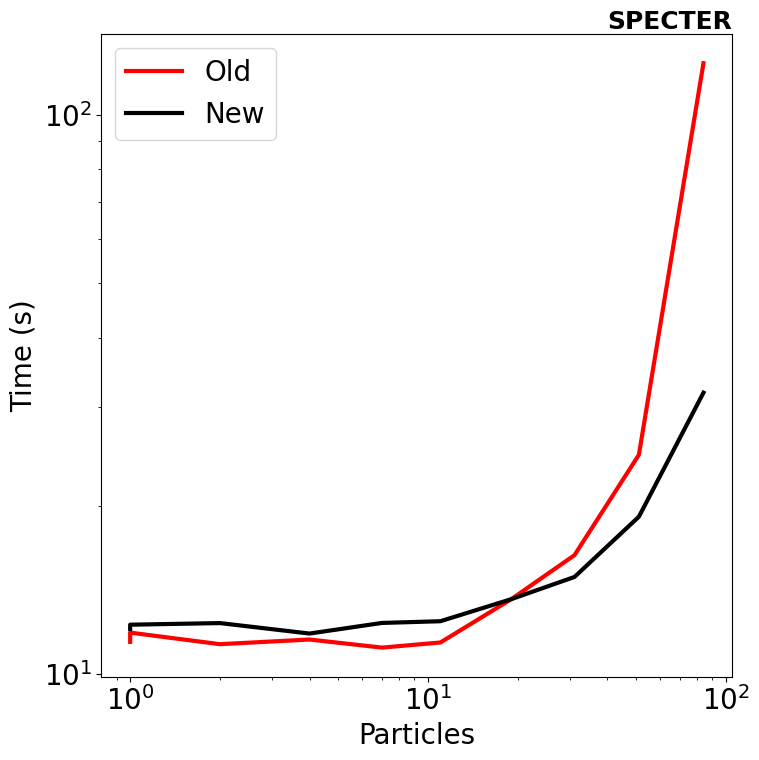

In [ ]:
# Plot the time taken for ds2 and ds2_improved as a function of pad size

print(n_times.shape)
n = n[:10]
newplot()
plt.plot(n, n_times[:,0], label = "Old")
plt.plot(n, n_times[:,1], label = "New")

# if nan, put an X at the previous point as a cutoff
for i in range(len(n_times)):
    if np.isnan(n_times[i,0]):
        plt.scatter(n[i-1], n_times[i-1,0], marker = "x", size = 10, color = "red")
        plt.text(n[i-1], n_times[i-1,0], "OoM!")
    if np.isnan(n_times[i,1]):
        plt.scatter(n[i-1], n_times[i-1,1], marker = "x", size = 10, color = "black")
        plt.text(n[i-1], n_times[i-1,1], "OoM!")

# calculate the index of the first nan, if any
try:
    nan_index = np.where(np.isnan(n_times[:,0]))[0][0]
except:
    nan_index = len(n_times) -1
print(nan_index)


# fit to n^a *  log n and find a
def fit_func(x, a, b):
    return a * x**b * np.log(x)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit_func, n[:nan_index], n_times[:nan_index,0])
print("Old: ", popt)
popt, pcov = curve_fit(fit_func, n, n_times[:,1])
print("New: ", popt)


plt.yscale('log')
plt.xscale('log')  
plt.xlabel("Particles") 
plt.ylabel("Time (s)")

plt.legend()
